## Linear vs Non Linear

#### First I do classification **with** softmax at the end

Can a Forward NN learn non-linear functions?
That may seem a trivial question but it is not!
First we train a CNN to classify the 10 FashionMNIST classes.

In [5]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline


# Decide if the system has GPUs
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(device)
print(dtype)

def save_everything(model_object,optimizer_object,filepath):
        """
        Save all the quantities related to model and optimizer
        """
        state = model_object.save_model()
        state['optimizer'] = optimizer_object.state_dict()
        torch.save(state, filepath)
        
def load_everything(model_object,optimizer_object,filepath):
        """
        Load all the quantities relateds to the object from file
        """
        state = torch.load(filepath,map_location='cpu')
        model_object.load_model(state)
        optimizer_object.load_state_dict(state['optimizer'])

def show_batch(images):
    """
    Simple function to show the images
    """
    im = torchvision.utils.make_grid(images)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
def show_names(labels):
    labels_dict={
        0 : "Tshirt",
        1 : "Trouser",
        2 : "Pullover",
        3 : "Dress",
        4 : "Coat",
        5 : "Sandal",
        6 : "Shirt",
        7 : "Sneaker",
        8 : "Bag",
        9 : "Ankle boot"}
    names = []
    for i in labels:
        names.append(labels_dict[i.item()])
    print(names)

cpu
<class 'torch.FloatTensor'>


In [2]:
class CNNModule(nn.Module):
    def __init__(self,criterion):
        super().__init__()
        
        # Auxiliary variables
        self.loss_history = []
        self.epoch = 0
        self.training_time = 0
        self.criterion=criterion
        
        # First Convolution Layer. The new image size remains unchanged:
        # Floor[ (28 + 2*padding - kernel_size)/stride + 1 ] = Floor[28+4-5+1] = 28x28 
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,stride=1,padding=2)
        self.relu1=nn.ReLU()
        nn.init.xavier_uniform_(self.cnn1.weight)

        # The max poll with kernel_size 2 reduces the image to size 14x14
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        # Second Convolution Layer. The new image size remains unchanged:
        # Floor[ (14 + 2*padding - kernel_size)/stride + 1 ] = Floor[14+4-5+1] = 14x14 
        self.cnn2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5,stride=1,padding=2)
        self.relu2=nn.ReLU()
        nn.init.xavier_uniform_(self.cnn2.weight)

        # The max poll with kernel_size 2 reduces the image to 7x7
        self.maxpool2=nn.MaxPool2d(kernel_size=2)

        # The last is a fully connected layer with 7x7xn_channel -> 10
        self.fcl=nn.Linear(32*7*7,10)
        self.softmax=nn.Softmax(dim=1)
    
    def forward(self,x):
        #First convolution
        out=self.cnn1(x)
        out=self.relu1(out)
        # Max pool
        out=self.maxpool1(out)
        # Second convolution
        out=self.cnn2(out)
        out=self.relu2(out)
        # Second convolution
        out=self.maxpool2(out)
        # Flattening
        out=out.view(out.size(0),-1)
        # Dense lyer
        out=self.fcl(out)
        out=self.softmax(out)
        return out
    
    def save_model(self):
        state={
            'state_dict': self.state_dict(),
            'loss_history': self.loss_history,
            'epoch': self.epoch,
            'training_time' : self.training_time
        }
        return state
            
    def load_model(self,state):
        self.load_state_dict(state['state_dict'])
        self.loss_history = state['loss_history']
        self.epoch = state['epoch']
        self.training_time = state['training_time']
    
    def compute_loss(self, output, target):
        loss = self.criterion(output,target)
        return loss
        
    
    def train_one_epoch(self,trainloader):
        
        tmp = [] 
        for i, data in enumerate(trainloader, 0): #loop over minibatches
            
            img, labels  = data
            images_in = Variable(img.to(device),requires_grad=False) #put the data on GPU if necessary
            
            # Run the VAE forward 
            output = self.forward(images_in)
            #print("xout",x_output.dtype)
            #print("xout",x_output.device)
            
            # Compute the loss
            loss = self.compute_loss(output,labels.to(device))
            #print("loss",loss.dtype)
            #print("loss",loss.device)
            
            # compute the average loss in this epoch
            tmp.append(loss.item()) # add the loss to the tmp list
            
            # For each minibatch set the gradient to zero
            optimizer.zero_grad()
            loss.backward()  # do backprop and compute all the gradients
            optimizer.step() # update the parameters
            
        # Svae the average loss during the epoch and the final value at the end of epoch
        self.loss_history.append(np.mean(tmp))
        self.epoch += 1
        
        
    def train(self,trainloader,DELTA_EPOCHS):
        import timeit
        tic=timeit.default_timer()
        
        for nn in range(DELTA_EPOCHS):
            self.train_one_epoch(trainloader)
            print("EPOCH loss=",self.epoch,self.loss_history[-1])
        
        toc=timeit.default_timer()
        self.training_time += toc - tic

1 28 28
['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt', 'Sandal', 'Sneaker', 'Coat', 'Sandal', 'Sneaker', 'Dress', 'Coat', 'Trouser', 'Pullover', 'Coat', 'Bag', 'Tshirt', 'Pullover', 'Sandal', 'Sneaker', 'Ankle boot', 'Trouser', 'Coat', 'Shirt', 'Tshirt', 'Ankle boot', 'Dress', 'Bag', 'Bag', 'Dress', 'Dress', 'Bag', 'Tshirt', 'Sneaker', 'Sandal', 'Sneaker', 'Ankle boot', 'Shirt', 'Trouser', 'Dress', 'Sneaker', 'Shirt', 'Sneaker', 'Pullover', 'Trouser', 'Pullover', 'Pullover', 'Coat', 'Coat', 'Sandal', 'Bag', 'Pullover', 'Pullover', 'Bag', 'Coat', 'Bag', 'Tshirt', 'Sneaker', 'Sneaker', 'Bag', 'Sandal']


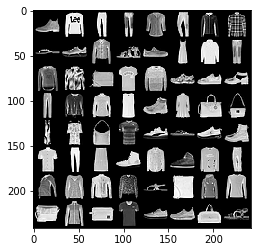

In [3]:
if __name__ == '__main__':
    
   
    BATCH_SIZE = 64

    transform = transforms.ToTensor()
    #transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

    # Load and transform data
    trainset = torchvision.datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

    testset = torchvision.datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Visualize the data and extract the image size
    images, labels =next(iter(trainloader))
    _, n_channel, height, width = images.size()
    print(n_channel,height, width)
   

    # Instanciates the CNN
    criterion=nn.CrossEntropyLoss()
    cnn = CNNModule(criterion).to(device) #note that here I am creating the model to either gpu or cpu
    
    # Select the optimizer
    #optimizer = optim.Adam(vae.parameters(), lr=0.0001)
    #optimizer = optim.RMSprop(vae.parameters())
    optimizer=torch.optim.SGD(cnn.parameters(),lr=0.015)
    

    # Save the same set of test images for testing   
    images_test_in, labels_test  = next(iter(testloader))
    
    # Look at the data
    show_batch(images_test_in)
    show_names(labels_test)

In [17]:
    for k in range(7,14):
        if(k>0):
            load_everything(cnn,optimizer,'./cnn_sofmax'+str(k-1)+'.pth')
        
        cnn.train(trainloader,10)  # train the model for 10 EPOCHS 
        save_everything(cnn,optimizer,'./cnn_softmax'+str(k)+'.pth')

        # Evaluate the accuracy on the test set
        with torch.no_grad():
            correct=0
            total=0
            for i, data in enumerate(testloader, 0):
                img,labels = data
                images_in = Variable(img.to(device),requires_grad=False) 
                output = cnn(images_in)              
                _,predicted=torch.max(output.data,1)
                total+=labels.size(0)
                correct+=(predicted==labels.to(device)).sum()
            accuracy= (100.0* correct)/(total)
            print("Iteration:"+str(cnn.epoch)+"  Loss:"+str(cnn.loss_history[-1])+"  Accuracy:"+str(accuracy.item()))

EPOCH loss= 71 1.6224632648262642
EPOCH loss= 72 1.6218926348665883
EPOCH loss= 73 1.6213851258444634
EPOCH loss= 74 1.6213519452477314
EPOCH loss= 75 1.6212874814899745
EPOCH loss= 76 1.6213647577045822
EPOCH loss= 77 1.62077638068433
EPOCH loss= 78 1.6207515885835009
EPOCH loss= 79 1.6205408784118034
EPOCH loss= 80 1.619836071152677
Iteration:80  Loss:1.619836071152677  Accuracy:82
EPOCH loss= 81 1.6197076774101014
EPOCH loss= 82 1.6196108886173792
EPOCH loss= 83 1.619435302102998
EPOCH loss= 84 1.6189889859543172
EPOCH loss= 85 1.6191066910208924
EPOCH loss= 86 1.61892753394682
EPOCH loss= 87 1.618496481416576
EPOCH loss= 88 1.6180078473680817
EPOCH loss= 89 1.617755945049115
EPOCH loss= 90 1.6179837592120871
Iteration:90  Loss:1.6179837592120871  Accuracy:83
EPOCH loss= 91 1.6176081439579473
EPOCH loss= 92 1.6173951295393107
EPOCH loss= 93 1.6168306651654274
EPOCH loss= 94 1.6171355205558255
EPOCH loss= 95 1.6165428059950058
EPOCH loss= 96 1.6167452708998722
EPOCH loss= 97 1.615931

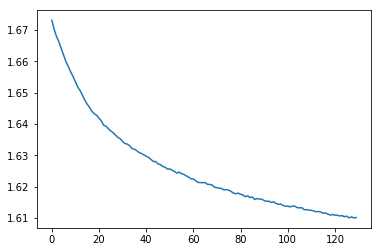

In [6]:
k=14
load_everything(cnn,optimizer,'./cnn_softmax'+str(k-1)+'.pth')
plt.plot(cnn.loss_history[10:])
#plt.semilogy(cnn.loss_history[10:])

Cool! We have achieved 84% accuracy on this data set.
**Now we analyze how the probability for the 10 classes change as a function of the input.**
We try:

\begin{equation}
\vec{y} = \text{CNN}(x +\epsilon \Delta x)
\end{equation}

where $\vec{y}$ is the 10 dimensional vector containing the probabilities for each class, $x$ is a test image which gave the right output and $\Delta x$ is a random 28x28 image

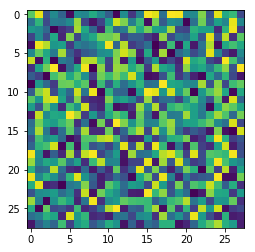

[[3.6920156e-28 3.8378129e-29 9.2610428e-19 1.1900012e-22 8.7630990e-26
  2.6008027e-04 1.9993994e-18 2.1329721e-05 4.5301995e-06 9.9971408e-01]]
[9]
['Ankle boot']
              0             1             2             3             4  \
0  3.692016e-28  3.837813e-29  9.261043e-19  1.190001e-22  8.763099e-26   

         5             6         7         8         9  
0  0.00026  1.999399e-18  0.000021  0.000005  0.999714  


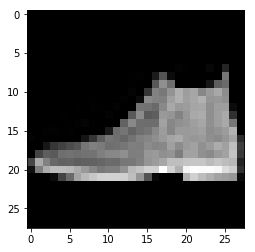

In [65]:
import pandas as pd

with torch.no_grad():
    
    # Load images 1 by 1 till you find one that is correctly predicted.
    # Then save that image and its probability for the 10 classes into data frame
    
    testloader_1_image = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
    for i in range(0,1):
        img, label = next(iter(testloader_1_image))
        output = cnn(img.to(device)) 
        _,predicted=torch.max(output.data,1)
        if(predicted==label.to(device)):
            base_img=img.to(device)
            base_prob=output.cpu().numpy()
            base_label=predicted.cpu().numpy()
            print(base_prob)
            print(base_label)
            show_names(base_label)
            show_batch(img)
            df = pd.DataFrame(base_prob)
            break
print(df)

In [66]:
with torch.no_grad():
    random_image = np.random.rand(height,width).astype(np.float32)
    #plt.imshow(random_image)
    dx=torch.from_numpy(np.reshape(random_image,img.size())).to(device)
    
    #print(base_img.dtype,base_img.size(),base_img.device) 
    #print(dx.dtype,dx.size(),dx.device) 
    epsilon = [0]
    for nep in range(1,10):
        ep = nep*0.1
        epsilon.append(ep)
        output_dx = cnn(base_img+ep*dx)
        df_tmp = pd.DataFrame(output_dx.cpu().numpy())
        #print(df_tmp)
        df=df.append(df_tmp,ignore_index=True)
        #df.append(pd.Series(), ignore_index=True)
    
    # Now add the column with the value of epsilon
    # and change the columns names
    eps = pd.Series(epsilon)
    df = df.assign(eps=eps.values)
    df=df.rename(index=str, columns={0: "p0", 1: "p1",2: "p2", 3: "p3",4: "p4", 5: "p5",6: "p6", 7: "p7",8: "p8", 9: "p9"})

              0             1             2             3             4  \
0  3.692016e-28  3.837813e-29  9.261043e-19  1.190001e-22  8.763099e-26   
1  4.232728e-29  4.561019e-29  1.353070e-18  1.924879e-23  2.746465e-27   
2  1.193602e-29  1.280095e-28  3.220999e-18  4.958826e-24  1.184400e-28   
3  4.736546e-30  4.520804e-28  8.013689e-18  1.659268e-24  6.576143e-30   
4  2.934318e-30  2.126590e-27  1.876834e-17  7.225854e-25  4.460954e-31   
5  1.619584e-30  9.769552e-27  3.220186e-17  2.203040e-25  2.832129e-32   
6  4.186560e-31  2.255894e-26  2.425361e-17  3.268786e-26  9.632118e-34   
7  2.566607e-32  1.190417e-26  4.106559e-18  1.207375e-27  8.403566e-36   
8  7.838120e-34  3.067169e-27  3.222125e-19  2.246890e-29  4.279847e-38   
9  2.489535e-35  7.996013e-28  2.578871e-20  4.172123e-31  1.993277e-40   

              5             6             7         8         9  eps  
0  2.600803e-04  1.999399e-18  2.132972e-05  0.000005  0.999714  0.0  
1  8.053969e-06  5.494368e-19  4

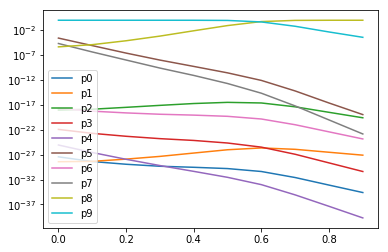

In [81]:
#print(df)
plt.semilogy( 'eps', 'p0', data=df)
plt.semilogy( 'eps', 'p1', data=df)
plt.semilogy( 'eps', 'p2', data=df)
plt.semilogy( 'eps', 'p3', data=df)
plt.semilogy( 'eps', 'p4', data=df)
plt.semilogy( 'eps', 'p5', data=df)
plt.semilogy( 'eps', 'p6', data=df)
plt.semilogy( 'eps', 'p7', data=df)
plt.semilogy( 'eps', 'p8', data=df)
plt.semilogy( 'eps', 'p9', data=df)
plt.legend()

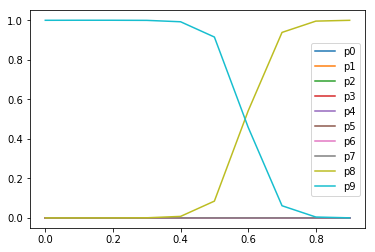

In [82]:
#print(df)
plt.plot( 'eps', 'p0', data=df)
plt.plot( 'eps', 'p1', data=df)
plt.plot( 'eps', 'p2', data=df)
plt.plot( 'eps', 'p3', data=df)
plt.plot( 'eps', 'p4', data=df)
plt.plot( 'eps', 'p5', data=df)
plt.plot( 'eps', 'p6', data=df)
plt.plot( 'eps', 'p7', data=df)
plt.plot( 'eps', 'p8', data=df)
plt.plot( 'eps', 'p9', data=df)
plt.legend()